In [56]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
import pickle 
from src import util_analysis 

In [57]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_3")
fig_out_dir.mkdir(exist_ok=True, parents=True)

In [58]:
room_manifest = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/manifest_room.pdpkl')
# for tuple_ in room_manifest.itertuples():
#     print(tuple_)
#     break
room_material_map = {}
for row in room_manifest.itertuples():
    wall1 = row.material_x0[0].split(',')[0]
    wall2 = row.material_y1[0].split(',')[0]
    if wall1 == wall2:
        wall_str = f"{wall1} walls"
    else:
        wall_str = f"{wall1} and {wall2} walls"

    floor = row.material_z0[0].split(',')[0]
    ceiling = row.material_z1[0].split(',')[0]
    name_str = f"{wall_str} \n {floor} floor \n {ceiling} ceiling"

    if row.index_room in [5, 6]:
        name_str = 'Alternate speaker room'
    if row.index_room in [6, 8]:
        name_str += ' \n head rotated'
    else:
        head_rotated = ''
    if 'Anechoic' in name_str:
        name_str = "Anechoic"
    room_material_map[row.index_room] = name_str
# room_material_map = {row.index_room: f"{row.material_x0[0].split(',')[0]} and \n {row.material_y1[0].split(',')[0]} walls \n {row.material_z0[0].split(',')[0]} floor \n {row.material_z1[0].split(',')[0]} ceiling" for row in room_manifest.itertuples()}
# room_material_map[5] = 'standard speaker room'
room_material_map

{0: 'Anechoic',
 1: 'Wood panelling on glass fiber blanket walls \n Carpet on foam rubber padding floor \n Highly absorptive panels ceiling',
 2: 'Brick walls \n Wood parquet on concrete floor \n Plaster ceiling',
 3: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling',
 4: 'Concrete walls \n Linoleum floor \n Acoustic tiles ceiling',
 5: 'Alternate speaker room',
 6: 'Alternate speaker room \n head rotated',
 7: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling',
 8: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling \n head rotated'}

In [59]:
import pickle 

manifest_path = "binaural_test_manifests/simulate_byrne_et_al_2023.pkl"
with open(manifest_path, "rb") as f: 
    manifest = pickle.load(f)
manifest_df  = pd.DataFrame(manifest.values())


In [60]:
output_paths = list(Path(f"binaural_eval/simulate_byrne_et_al_2023/").glob("*/*.pkl"))


In [61]:
output_paths = list(Path(f"binaural_eval/simulate_byrne_et_al_2023/").glob("*/*.pkl"))

stim_manifest_df = pd.read_pickle('/om/user/imgriff/datasets/human_word_rec_SWC_2024/full_cue_target_distractor_df_w_meta.pdpkl')

word_class_map = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
ix_to_word = {v:k for k,v in word_class_map.items()}

remap_azim = lambda azim: 360 - azim if azim > 180 else 0 - azim 

results_dfs = []

def get_model_name(stem):
    if 'late_only' in stem:
        return 'Late-only'
    elif 'early_only' in stem:
        return 'Early-only'
    elif 'control' in stem:
        return 'Baseline CNN'
    elif 'arch' in stem:
        arch_n = stem.split('_')[-1]
        return f'Feature-gain alt v{arch_n}'
    elif 'rand' in stem:
        return 'Feature-gain random weights'
    elif "main" in stem:
        return 'Feature-gain main'

model_stems = np.unique([path.parent.stem for path in output_paths])
model_name_dict = {stem: get_model_name(stem) for stem in model_stems}
wanted_models = list(model_name_dict.keys())

anechoic_room_str = "eval_room0000"

for path in output_paths:
    # if not any(name in str(path) for name in wanted_models):# 'word_task_half_co_loc_v08']):
    #     continue
    # if 'modulated' in path.stem:
    #     continue 
    # if not anechoic_room_str in path.stem:
    #     continue
    res_dict = pickle.load(open(path, 'rb'))
    df = pd.DataFrame.from_dict(res_dict)
    # break
    df.rename(columns={"results": "accuracy"}, inplace=True)
    df['model'] = model_name_dict[path.parent.stem]

    # # # merge with stim manifest
    df.loc[df.index.values, ['word', 'distractor_word','sex_cond']] = stim_manifest_df.loc[df.stim_ix_list.values, ['word', 'distractor_word','sex_cond']].values
    df['target_word'] = df['true_word_int'].map(ix_to_word)
    df['pred_word'] = df['preds'].map(ix_to_word)
    df['correct'] = (df['true_word_int'] == df['preds']).astype('int')
    df['str_confusions'] = df[['pred_word', 'distractor_word']].apply(lambda x: 1 if x.pred_word in x.distractor_word else 0, axis=1)
    if 'clean' in path.stem:
        snr = 'clean'
    else:
        snr = int(re.search('(-?\d+)_SNR', path.stem).group(0).strip('_SNR'))
        
    df['snr'] = snr 
    df["target_azim"], df["target_elev"] = path.stem.split('target_loc_')[1].split('_distract_loc_')[0].split('_')
    df["distractor_azim"], df["distractor_elev"] = path.stem.split('_distract_loc_')[1].split('_')[:2]
    # # map azim to 0-180
    df['target_azim'] = df['target_azim'].astype(int).apply(remap_azim)
    df['distractor_azim'] = df['distractor_azim'].astype(int).apply(remap_azim)
    df['target_elev'] = df['target_elev'].astype(int)
    df['distractor_elev'] = df['distractor_elev'].astype(int)
    df['room_ix'] = int(re.search('room(-?\d+)', path.stem).group(0).strip('room'))
    df['room_type'] = re.search('SNR_(.*?)_room', path.stem).group(0).split('SNR_')[-1].split("_room")[0]
    df['n_distractors'] = 1 if '1_distractor' in path.stem else 2
    df['test_set'] = 'all_stim' if 'all_stim' in path.stem else 'subset'
    if 'white_noise' in path.as_posix():
        df['distractor_type'] = 'white_noise'
    elif 'texture' in path.as_posix():
        df['distractor_type'] = 'texture'
    else:
        df['distractor_type'] = 'speech'
    results_dfs.append(df)

results = pd.concat(results_dfs)

In [62]:
results.groupby('model').snr.value_counts().unique()

array([9760, 7808, 5856])

In [63]:
results.loc[results.room_type.str.contains('eval'), 'room_str'] = results.loc[results.room_type.str.contains('eval'), 'room_ix'].map(room_material_map)

results.loc[results.room_type.str.contains('mitb46'), 'room_str'] = 'Normal speaker array'
results.loc[results.room_type.str.contains('mitb46'), 'room_ix'] = 9 # use n from diff room notebook

results.loc[results.room_type.str.contains('reverb'), 'room_str'] = 'Min. reverb speaker array'
results.loc[results.room_type.str.contains('reverb'), 'room_ix'] = 10 # use n from diff room notebook

In [64]:
grouped_results = results.groupby(['model', 'target_azim', 'target_elev', 'distractor_azim',
                                   'distractor_elev', 'sex_cond', 'snr']).agg({'accuracy':['mean', 'sem'],
                                                            'confusions':['mean', 'sem']}).reset_index()
# flatten multiindex
grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]
# remove trailing underscore
grouped_results.columns = [col[:-1] if col[-1] == '_' else col for col in grouped_results.columns.values]



In [65]:
grouped_results.model.unique()

array(['Baseline CNN', 'Early-only', 'Feature-gain alt v1',
       'Feature-gain alt v10', 'Feature-gain alt v12',
       'Feature-gain alt v2', 'Feature-gain alt v4',
       'Feature-gain alt v6', 'Feature-gain alt v7',
       'Feature-gain alt v8', 'Feature-gain alt v9', 'Feature-gain main',
       'Late-only'], dtype=object)

In [66]:
# fba_model = grouped_results[grouped_results.model.str.contains('Feature-gain')].copy().reset_index(drop=True)   
# fba_model = fba_model.groupby(['target_azim', 'target_elev', 'distractor_azim',
#                                    'distractor_elev', 'sex_cond', 'snr']).agg({'accuracy_mean':['mean', 'sem'],
#                                                             'confusions_mean':['mean', 'sem']}).reset_index()

# # flatten multiindex
# fba_model.columns = ['_'.join(col).strip() for col in fba_model.columns]
# fba_model.columns = [col[:-1] if col[-1] == '_' else col for col in fba_model.columns.values]

# fba_model = fba_model.rename(columns={'accuracy_mean_mean': 'accuracy', 'accuracy_mean_sem': 'accuracy_sem',
#                                       'confusions_mean_mean': 'confusions', 'confusions_mean_sem': 'confusions_sem'})
# fba_model['model'] = 'Feature-gain model'
# fba_model

In [67]:
### Byrne et al. 2023 data 

byrne_data = np.array([-0.09484242924828479, 0.4982925897160886,
                        5.013827763189802, -3.951329561004476,
                        10.05543433148005, -10.226709567661526,
                        19.95734556258245, -13.644653196411767,
                        39.96515321490358, -15.760526975438765,
                        0.022518913010429742, -11.306631162395057,
                        5.0401272236399315, -11.078483342990165,
                        10.065132257521036, -12.854847524768747,
                        19.96030425188309, -14.446457996885155,
                        39.8901997526207, -15.448138696779548]).reshape(-1, 2)
                        
byrne_data = pd.DataFrame({'distractor_azim':byrne_data[:,0], 'threshold_snr':byrne_data[:,1]})
byrne_data['dist_type'] = ["speech"] * 5 + ["noise"] * 5 
byrne_data['distractor_azim'] = byrne_data['distractor_azim'].astype(int).abs()
byrne_data

,distractor_azim,threshold_snr,dist_type
0,0,0.498293,speech
1,5,-3.951330,speech
2,10,-10.226710,speech
3,19,-13.644653,speech
4,39,-15.760527,speech
5,0,-11.306631,noise
6,5,-11.078483,noise
7,10,-12.854848,noise
8,19,-14.446458,noise
9,39,-15.448139,noise


In [68]:
outfig_dest = Path('final_figures')
outfig_dest.mkdir(parents=True, exist_ok=True)

In [69]:
grouped_results.model.unique()

array(['Baseline CNN', 'Early-only', 'Feature-gain alt v1',
       'Feature-gain alt v10', 'Feature-gain alt v12',
       'Feature-gain alt v2', 'Feature-gain alt v4',
       'Feature-gain alt v6', 'Feature-gain alt v7',
       'Feature-gain alt v8', 'Feature-gain alt v9', 'Feature-gain main',
       'Late-only'], dtype=object)

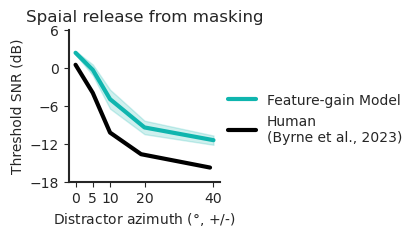

In [77]:


human_str = "Human\n(Byrne et al., 2023)"

model_to_plot = grouped_results[grouped_results.model.str.contains('Feature') & grouped_results.sex_cond.str.contains('same')].copy() # already filtered for wanted data 
model_to_plot['distractor_azim'] = model_to_plot['distractor_azim'].astype(int).abs()
model_to_plot = model_to_plot[model_to_plot.distractor_azim <= 40]



# get threshold for each target azimuth and dist_type
model_thresholds = []
for (model, azim), group in model_to_plot.groupby(['model', 'distractor_azim']):
    thresh_val = model_to_plot.loc[model_to_plot.model == model, 'accuracy_mean'].max() * 0.5
    # print(model, group.shape)
    thresh, fit_popt = util_analysis.estimate_threshold_poly(group.snr.values, group.accuracy_mean.values, threshold=thresh_val, degree=2)
    # try:
    #     # thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.accuracy_mean.values, threshold_value='half', bounds_from_data=True)
    # except Exception as e:
    #     print(f"Error estimating threshold for model {model} with azim {azim}: {e}")
    #     thresh = np.nan
    model_thresholds.append({'model': model, 'distractor_azim': azim, 'threshold_snr':thresh}) #  'gender_cond':gend_cond,


model_thresholds_df = pd.DataFrame(model_thresholds)



# add byrne data to model_to_plot
byrne_data['model'] = human_str
byrne_data['group'] = human_str
model_thresholds_df['group'] = 'Feature-gain Model'
byrne_data_to_plot = byrne_data[byrne_data.dist_type.eq('speech')].copy()
data_to_plot = pd.concat([model_thresholds_df, byrne_data_to_plot], axis=0, ignore_index=True)
# data_to_plot = data_to_plot[data_to_plot.dist_type == 'speech']
# make a palette for noise and speech where speech is black and noise is blue
# palette = {'speech':'k', 'noise':'r'}


## add masking release 
for model in data_to_plot.model.unique():
    data_to_plot.loc[data_to_plot.model == model, 'masking_release'] = data_to_plot.loc[data_to_plot.model == model, 'threshold_snr'] - data_to_plot.loc[data_to_plot.model == model, 'threshold_snr'].max()

models = ['Feature-gain Model', ]#'Early-only', 'Late-only', 'Baseline CNN']

# cmap = sns.color_palette("viridis", n_colors=1)
# palette = dict(zip(models, cmap))
palette = {}
palette[human_str] = 'k'
palette['Feature-gain Model'] = util_analysis.model_color_dict['Feature-gain Model']

# col_order = [human_str, 'Model']
sns.set_style('ticks')
# plot 

g = sns.relplot(data=data_to_plot, x='distractor_azim', y='threshold_snr',
              #  col = 'model',# col_order=col_order,
                hue='group', palette=palette, 
                # alpha=0.5,
                # style='model', style_order=[human_str] + models,
                kind='line', linewidth=3, zorder=5, legend=True,
                facet_kws={'sharey':False},
                errorbar=('se', 2), height=2.25, aspect=1.25, )

g.axes[0][0].set_title("Spaial release from masking")
g.set_axis_labels("Distractor azimuth ($\degree$, +/-)", "Threshold SNR (dB)")
g.set_titles("{col_name}")

# plt.suptitle("Symmetric distractor positions", y=1.05)
g.set(yticks=np.arange(-18,  7, 6))
# g.legend.remove()

g._legend.set_title("")
 
# move  legend of g to the right
# g._legend.set_bbox_to_anchor([0.7, 0.75])

x_tick_locs = np.sort(model_to_plot.distractor_azim.unique())
x_tick_labels = [str(x) for x in x_tick_locs]
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticks(ticks=x_tick_locs) # set new labels
    ax.set_xticklabels(labels=x_tick_labels)

ratio = 1 
for ax in g.axes.flat:
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
# save figure as svg 
# plt.tight_layout()
# plt.savefig(outfig_dest/'symmetric_distractor_thresholds.pdf', transparent=True, bbox_inches='tight')

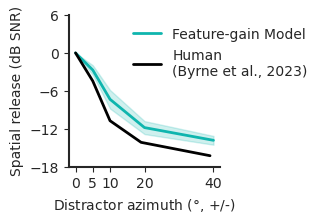

In [71]:
sns.set_style('ticks')
# plot 

g = sns.relplot(data=data_to_plot, x='distractor_azim', y='masking_release',
              #  col = 'model',# col_order=col_order,
                hue='group', palette=palette, 
                # alpha=0.5,
                # style='model', style_order=[human_str] + models,
                kind='line', linewidth=2, zorder=5, legend=True,
                facet_kws={'sharey':False},
                errorbar=('se', 2), height=2.25, aspect=1.25, )

# g.axes[0][0].set_title("Spaial release from masking")
g.set_axis_labels("Distractor azimuth ($\degree$, +/-)", "Spatial release (dB SNR)")
g.set_titles("{col_name}")

# plt.suptitle("Symmetric distractor positions", y=1.05)
g.set(yticks=np.arange(-18,  7, 6))
g.legend.remove()

g._legend.set_title("")

# reduce fontsize in legend 
# for text in g._legend.texts:
#     text.set_fontsize(8)
 
g.axes[0,0].legend(bbox_to_anchor=(1, 0.75), loc='center', fontsize=10, title_fontsize=8, frameon=False)
# move  legend of g to the right
# g._legend.set_bbox_to_anchor([0.7, 0.75])
# g.axes[0,0].legend(bbox_to_anchor=(0.5, 0.5), loc='center', fontsize=8, title_fontsize=8)

x_tick_locs = np.sort(model_to_plot.distractor_azim.unique())
x_tick_labels = [str(x) for x in x_tick_locs]
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticks(ticks=x_tick_locs) # set new labels
    ax.set_xticklabels(labels=x_tick_labels)

ratio = 1 
for ax in g.axes.flat:
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)

plt.savefig(fig_out_dir/'human_v_model_srm.pdf', transparent=True, bbox_inches='tight')


In [72]:
util_analysis.model_color_dict

{'Feature-gain Model': '#0FB5AE',
 'Baseline CNN': '#808080',
 'Early-only': '#4046CA',
 'Late-only': '#F68511',
 '50Hz cutoff': '#DE3D82'}

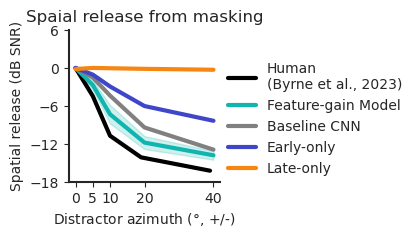

In [80]:


human_str = "Human\n(Byrne et al., 2023)"

model_to_plot = grouped_results[grouped_results.sex_cond.str.contains('same')].copy() # already filtered for wanted data 
model_to_plot['distractor_azim'] = model_to_plot['distractor_azim'].astype(int).abs()
model_to_plot = model_to_plot[model_to_plot.distractor_azim <= 40]



# get threshold for each target azimuth and dist_type
model_thresholds = []
for (model, azim), group in model_to_plot.groupby(['model', 'distractor_azim']):
    thresh_val = model_to_plot.loc[model_to_plot.model == model, 'accuracy_mean'].max() * 0.5
    # print(model, group.shape)
    thresh, fit_popt = util_analysis.estimate_threshold_poly(group.snr.values, group.accuracy_mean.values, threshold=thresh_val, degree=2)
    # try:
    #     # thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.accuracy_mean.values, threshold_value='half', bounds_from_data=True)
    # except Exception as e:
    #     print(f"Error estimating threshold for model {model} with azim {azim}: {e}")
    #     thresh = np.nan
    model_thresholds.append({'model': model, 'distractor_azim': azim, 'threshold_snr':thresh}) #  'gender_cond':gend_cond,


model_thresholds_df = pd.DataFrame(model_thresholds)

model_thresholds_df.loc[model_thresholds_df.model.str.contains('Feature-gain'), 'group'] = 'Feature-gain Model'
model_thresholds_df.loc[model_thresholds_df.model.str.contains('Baseline CNN'), 'group'] = 'Baseline CNN'
model_thresholds_df.loc[model_thresholds_df.model.str.contains('Early-only'), 'group'] = 'Early-only'
model_thresholds_df.loc[model_thresholds_df.model.str.contains('Late-only'), 'group'] = 'Late-only'

# add byrne data to model_to_plot
byrne_data['model'] = human_str
byrne_data['group'] = human_str
# model_thresholds_df['group'] = 'Feature-gain model'
byrne_data_to_plot = byrne_data[byrne_data.dist_type.eq('speech')].copy()
data_to_plot = pd.concat([model_thresholds_df, byrne_data_to_plot], axis=0, ignore_index=True)
# data_to_plot = data_to_plot[data_to_plot.dist_type == 'speech']
# make a palette for noise and speech where speech is black and noise is blue
# palette = {'speech':'k', 'noise':'r'}


## add masking release 
for model in data_to_plot.model.unique():
    data_to_plot.loc[data_to_plot.model == model, 'masking_release'] = data_to_plot.loc[data_to_plot.model == model, 'threshold_snr'] - data_to_plot.loc[data_to_plot.model == model, 'threshold_snr'].max()

models = ['Feature-gain Model', 'Baseline CNN', 'Early-only', 'Late-only']

# cmap = sns.color_palette("tab10", n_colors=len(models))
# palette = dict(zip(models, cmap))

palette[human_str] = 'k'
palette.update(util_analysis.model_color_dict)
# palette.update(other_models)

# col_order = [human_str, 'Model']
sns.set_style('ticks')
# plot 

g = sns.relplot(data=data_to_plot, x='distractor_azim', y='masking_release',
                hue_order = [human_str] + models,
                hue='group', palette=palette, 
                # alpha=0.5,
                # style='model', style_order=[human_str] + models,
                kind='line', linewidth=3, zorder=5, legend=True,
                facet_kws={'sharey':False},
                errorbar=('se', 2), height=2.25, aspect=1.25, )

g.axes[0][0].set_title("Spaial release from masking")
g.set_axis_labels("Distractor azimuth ($\degree$, +/-)", "Spatial release (dB SNR)")
g.set_titles("{col_name}")

# plt.suptitle("Symmetric distractor positions", y=1.05)
g.set(yticks=np.arange(-18,  7, 6))
# g.legend.remove()

g._legend.set_title("")
 
# move  legend of g to the right
# g._legend.set_bbox_to_anchor([0.7, 0.75])

x_tick_locs = np.sort(model_to_plot.distractor_azim.unique())
x_tick_labels = [str(x) for x in x_tick_locs]
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticks(ticks=x_tick_locs) # set new labels
    ax.set_xticklabels(labels=x_tick_labels)

ratio = 1 
for ax in g.axes.flat:
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
# save figure as svg 
# plt.tight_layout()
# plt.savefig(fig_out_dir/'sup_figure_6.pdf', transparent=True, bbox_inches='tight')


In [79]:
fig_out_dir

PosixPath('final_figures/figure_3')

In [147]:
from pingouin import rm_anova

for_anova = data_to_plot[data_to_plot.group == 'Feature-gain model'].copy()

rm_anova_table = rm_anova(data=for_anova, dv='threshold_snr', subject='model', within=["distractor_azim"], effsize='np2')
print("ANOVA for model")
rm_anova_table

ANOVA for model


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,distractor_azim,4,36,412.485071,1.585491e-29,1.988513e-11,0.978647,0.343487,False,0.006393,0.000033
